# Directory settings

# About this notebook

The goal of this notebook is to improve the results of the [notebook](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43#Train-DataLoader) shared by @cdeotte and [@alejopaullier](https://www.kaggle.com/code/alejopaullier/hms-efficientnetb0-pytorch-train), please check them out great notebooks.


**Important note**:

I shared in the last days a [discussion](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/478474) which was an Improvement of this [notebook](https://www.kaggle.com/code/nischaydnk/hms-submission-1d-eegnet-pipeline-lightning) created by @nischaydnk. The tricks I used were notably changing the optimizer (I used Adan) and I used the two stage training as stated by @seanbearden [here](https://www.kaggle.com/code/seanbearden/effnetb0-2-pop-model-train-twice-lb-0-39) and not using downsampling which worked pretty well.
But the two stage training an issue which is data leakage. The idea was to seperate the data with few votes because the kl will hardly penalize the model if it mislabel them. So in my previous experiments I use two groupkfold CV on the two datasets and the samples with few votes are present in both datasets.

So in this notebook, I use one CV scheme and in each stage I filter the data then validate on the data that contains both population to prevent data leakage. Let me know in the comment if this approach is correct more info can be found [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/477461).

As stated [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/477498), adding 0.166666667 to the targets will reduce the CV/LB gap.

**Consider upvoting this notebook if you find it useful**

## Version 1
* I train a tf_efficientnet_b0_ns model.

### Hyperparams

```
scheduler='OneCycleLR' 
 # OneCycleLR params
  cosanneal_res_params={
      'T_0':20,
      'eta_min':1e-6,
      'T_mult':1,
      'last_epoch':-1}
  print_freq=50
  num_workers = 1
  model_name = 'tf_efficientnet_b0_ns'
  optimizer='Adam'
  stage1_epochs = 5
  stage1_epochs = 6
  eps = 1e-6
  lr = 1e-3
  batch_size = 64
  weight_decay = 1e-2
  seed = 2024
```

## Version2

* I changed the CV sheme, first stage train on all data second stage train on data with `total_evaluators >= 10`
* Added Time masking augmentation from [here](https://www.kaggle.com/code/iglovikov/xymasking-aug).

In [1]:
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 78.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
# ====================================================
# directory settings
# ====================================================

import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
POP_2_DIR = OUTPUT_DIR + 'pop_2_weight_oof/'
if not os.path.exists(POP_2_DIR):
    os.makedirs(POP_2_DIR)
    
POP_1_DIR = OUTPUT_DIR + 'pop_1_weight_oof/'
if not os.path.exists(POP_1_DIR):
    os.makedirs(POP_1_DIR)
    
PSUEDO_DIR = OUTPUT_DIR + 'psuedo_labels_weights/'
if not os.path.exists(PSUEDO_DIR):
    os.makedirs(PSUEDO_DIR)

# Libraries

In [3]:
import os
import gc
from glob import glob
import sys
import math
import time
import random
import shutil
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
from scipy.stats import entropy
from scipy.signal import butter, lfilter, freqz
from contextlib import contextmanager
from collections import defaultdict, Counter
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from tqdm.auto import tqdm
from functools import partial
import cv2
from PIL import Image
import torch
from torch import Tensor
import torch.nn as nn
import pytorch_lightning as lg
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose)
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm
import warnings 
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import joblib

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
VERSION=2

# We added the pre-calculated mean and std
MEAN = torch.load('/kaggle/input/mean-and-std-spectrograms/mean.pt').numpy()
STD = torch.load('/kaggle/input/mean-and-std-spectrograms/std_dev.pt').numpy()

# We added the pre-calculated pseudo labels
efficentnet_model_psuedo_weights = [x for x in glob("/kaggle/input/mixmodel-weights/psuedo_labels_weights/*.pth")]

# Config

In [4]:
# ====================================================
# CFG
# ====================================================

class CFG:
    wandb = False
    debug = False
    train=True
    apex=True
    stage1_pop1=True
    stage2_pop2=False
    VISUALIZE=True
    FREEZE=False
    SparK=False
    scheduler='OneCycleLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':6,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':20,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    print_freq=50
    num_workers = 1
    model_name = 'tf_efficientnet_b0_ns'
    optimizer='Adan'
    epochs = 5
    factor = 0.9
    patience = 2
    eps = 1e-6
    lr = 1e-3
    min_lr = 1e-6
    batch_size = 64
    weight_decay = 1e-2
    batch_scheduler=True
    gradient_accumulation_steps = 1
    max_grad_norm = 1e7
    seed = 2024
    target_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    target_size = 6
    num_channels = 8
    pred_cols = ['pred_seizure_vote', 'pred_lpd_vote', 'pred_gpd_vote', 'pred_lrda_vote', 'pred_grda_vote', 'pred_other_vote']
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
    data_root = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    raw_eeg_path = "/kaggle/input/brain-eegs/eegs.npy"

# Utils

In [5]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def get_score(preds, targets):
    oof = pd.DataFrame(preds.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(targets.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    return cv

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
seed_torch(seed=CFG.seed)

# Load train data

In [6]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = train.columns[-6:]
print('Train shape:', train.shape )
print('Targets', list(TARGETS))

train['total_evaluators'] = train[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)

print(f'There are {train.patient_id.nunique()} patients in the training data.')
print(f'There are {train.eeg_id.nunique()} EEG IDs in the training data.')

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1950 patients in the training data.
There are 17089 EEG IDs in the training data.


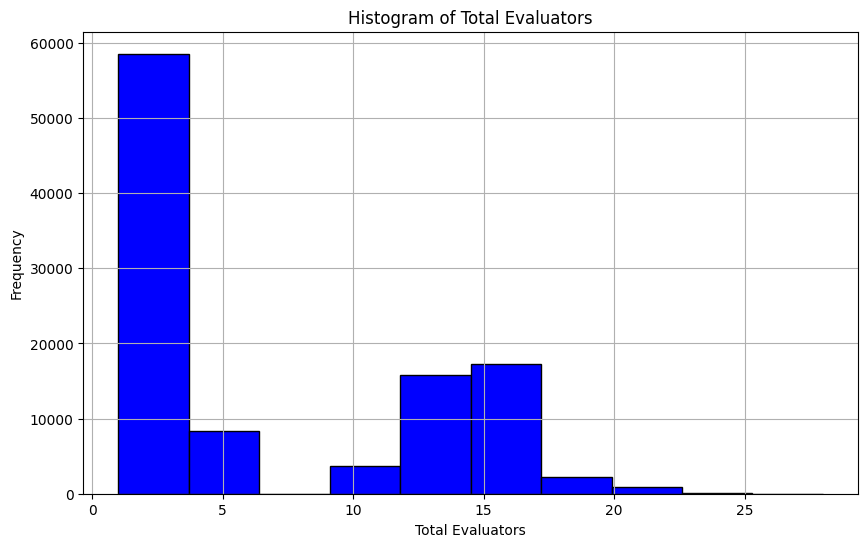

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
%%time
spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy', allow_pickle=True).item()

CPU times: user 3.39 s, sys: 6.64 s, total: 10 s
Wall time: 59.2 s


In [9]:
%%time
all_eegs = np.load('/kaggle/input/eeg-spectrogram-by-lead-id-unique/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 6.33 s, sys: 10.9 s, total: 17.3 s
Wall time: 1min 26s


# Deduplicate Train EEG Id

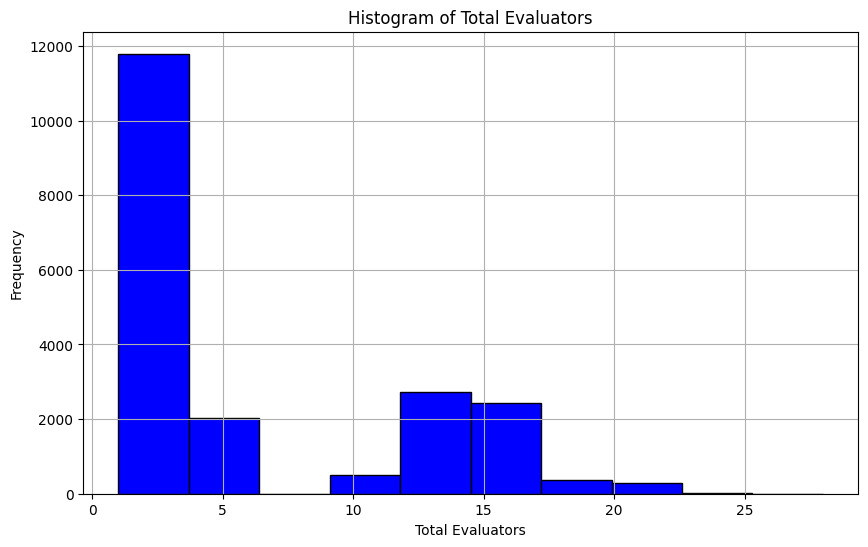

In [12]:
train = train[train['label_id'].isin(all_eegs.keys())].copy()

# Implentation for pseudo labels
mask = train['total_evaluators'] < 10

pseudo_labels = np.load('/kaggle/input/mixmodel-weights/pseudo_labels.npy')
pseudo_labels = F.softmax(torch.tensor(pseudo_labels), dim=1).numpy()

y_data = train[TARGETS].values + np.multiply(np.expand_dims(mask, axis=1), pseudo_labels)

# y_data = train[TARGETS].values +  0.166666667 # Regularization value # We removed this from the code, as it did not improve the LB scores and used pseudo labels instead.
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

train['target'] = train['expert_consensus']

train = train.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

del y_data
_ = gc.collect()

# CV Scheme

In [13]:
gkf = GroupKFold(n_splits=CFG.n_fold)

train["fold"] = -1

for fold_id, (_, val_idx) in enumerate(
    gkf.split(train, y=train["target"], groups=train["patient_id"])
):
    train.loc[val_idx, "fold"] = fold_id
    
del gkf
_ = gc.collect()

# Dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame,
        augment: bool = False, mode: str = 'train',
        specs: Dict[int, np.ndarray] = spectrograms,
        eeg_specs: Dict[int, np.ndarray] = all_eegs
    ): 
        self.df = df
        self.augment = augment
        self.mode = mode
        self.spectograms = spectrograms
        self.eeg_spectograms = eeg_specs
        
    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X, y = self.__data_generation(index)
        if self.augment:
            X = self.__transform(X) 
        return {"spectrogram":torch.tensor(X, dtype=torch.float32), "labels":torch.tensor(y, dtype=torch.float32)}
                        
    def __data_generation(self, index):
        """
        Generates data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        img = np.ones((128,256), dtype='float32')
        row = self.df.iloc[index]
        if self.mode=='test': 
            r = 0
        else: 
            r = int(row['spectrogram_label_offset_seconds'] // 2)
            
        for region in range(4):
            img = self.spectograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Remove local normalization
#             # Standarize per image
#             ep = 1e-6
#             mu = np.nanmean(img.flatten())
#             std = np.nanstd(img.flatten())
#             img = (img-mu)/(std+ep)

            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectograms[row.label_id]
            X[:, :, 4:] = img
            
        if self.mode != 'test':
            y = row[TARGETS].values.astype(np.float32)
        
        # Added global normalization
        ep = 1e-6
        X = (X - MEAN) / (STD+ep)
        X = np.nan_to_num(X, nan=0.0)
        
        return X, y
    
    def __transform(self, img):
        params1 = {
                    "num_masks_x": 1,    
                    "mask_x_length": (0, 20), # This line changed from fixed  to a range
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),
                    }
        params2 = {    
                    "num_masks_y": 1,    
                    "mask_y_length": (0, 20),
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),    
                    }
        params3 = {    
                    "num_masks_x": (2, 4),
                    "num_masks_y": 5,    
                    "mask_y_length": 8,
                    "mask_x_length": (10, 20),
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),  
                    }
        
        transforms = A.Compose([
            A.XYMasking(**params1, p=0.3),
            A.XYMasking(**params2, p=0.3),
            A.XYMasking(**params3, p=0.3),
        ])
        return transforms(image=img)['image']

# Dataloader

In [15]:
# dataset = CustomDataset(train, augment=True, mode="train")
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# batch = dataset[4]
# X, y = batch["spectrogram"], batch["labels"]
# print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")

# plt.imshow(X[:,:,0])

# del dataset, X, y
# _ = gc.collect()

In [16]:
# Creation of global mean and std

# dataset = CustomDataset(train, augment=False, mode="test")
# dataloader = DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False)

# batch = dataset[0]
# X, y = batch["spectrogram"], batch["labels"]

# total_sum_mean = torch.zeros(X.shape)
# total_samples_mean = 0

# total_sum_var = torch.zeros(X.shape)
# total_samples_var = 0

# for i, batch in enumerate(dataloader):
#     if i%10==0: print(i, end=", ")
#     X = batch["spectrogram"]
    
#     total_sum_mean += torch.sum(X, dim=0)
#     total_samples_mean += X.size(0)

# # Compute mean
# mean = total_sum_mean / total_samples_mean
# torch.save(mean, 'mean.pt')

# for i, batch in enumerate(dataloader):
#     if i%10==0: print(i, end=", ")
#     X = batch["spectrogram"]
    
#     total_sum_var += torch.sum((X - mean) ** 2, dim=0)
#     total_samples_var += X.size(0)
    
# std_dev = torch.sqrt(total_sum_var / total_samples_var)
# torch.save(std_dev, 'std_dev.pt')  

In [17]:
# if CFG.VISUALIZE:
#     ROWS = 2
#     COLS = 3
#     for batch in dataloader:
#         X, y = batch["spectrogram"], batch["labels"]
#         plt.figure(figsize=(20,8))
#         for row in range(ROWS):
#             for col in range(COLS):
#                 plt.subplot(ROWS, COLS, row*COLS + col+1)
#                 t = y[row*COLS + col]
#                 img = X[row*COLS + col, :, :, 0]
#                 mn = img.flatten().min()
#                 mx = img.flatten().max()
#                 img = (img-mn)/(mx-mn)
#                 plt.imshow(img)
#                 tars = f'[{t[0]:0.2f}'
#                 for s in t[1:]:
#                     tars += f', {s:0.2f}'
#                 eeg = train.eeg_id.values[row*CFG.batch_size + row*COLS + col]
#                 plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
#                 plt.yticks([])
#                 plt.ylabel('Frequencies (Hz)',size=14)
#                 plt.xlabel('Time (sec)',size=16)
#         plt.show()
#         break
        
# del dataloader
# _ = gc.collect()

# Model

In [18]:
class CustomModel(nn.Module):
    def __init__(self, config, num_classes: int = 6, pretrained: bool = True):
        super(CustomModel, self).__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.model = timm.create_model(
            config.model_name,
            pretrained=pretrained,
        )
        if config.FREEZE:
            for i,(name, param) in enumerate(list(self.model.named_parameters())\
                                             [0:config.NUM_FROZEN_LAYERS]):
                param.requires_grad = False

        self.features = nn.Sequential(*list(self.model.children())[:-2])
        self.custom_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.model.num_features, num_classes)
        )

    def __reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # === Get spectograms ===
        spectograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectograms = torch.cat(spectograms, dim=1)
        
        # === Get EEG spectograms ===
        eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # === Reshape (512,512,3) ===
        if self.USE_KAGGLE_SPECTROGRAMS & self.USE_EEG_SPECTROGRAMS:
            x = torch.cat([spectograms, eegs], dim=2)
        elif self.USE_EEG_SPECTROGRAMS:
            x = eegs
        else:
            x = spectograms
            
        x = torch.cat([x,x,x], dim=3)
        x = x.permute(0, 3, 1, 2)
        return x
    
    def forward(self, x):
        x = self.__reshape_input(x)
        x = self.features(x)
        x = self.custom_layers(x)
        return x

In [19]:
# iot = torch.randn(2, 128, 256, 8)
# model = CustomModel(CFG)
# output = model(iot)
# print(output.shape)

# del iot, model, output
# gc.collect()
# torch.cuda.empty_cache()

In [20]:
# Creation of pseudo labels

# dataset = CustomDataset(train, augment=False, mode="train")
# data_loader = DataLoader(dataset, batch_size=128, shuffle=False)

# softmax = nn.Softmax(dim=1)

# def generate_pseudo_labels(model, data_loader):
#     pseudo_labels = []
#     for batch in data_loader:
#         X, y = batch["spectrogram"].to(device), batch["labels"].to(device)
#         with torch.no_grad():
#             outputs = model(X)
#             outputs = softmax(outputs)
        
#         pseudo_labels.append(outputs.detach().cpu().numpy())  
#     pseudo_labels = np.concatenate(pseudo_labels, axis=0)
#     return pseudo_labels


# pseudo_labels_folds = []

# for weights in efficentnet_model_psuedo_weights:
#     model = CustomModel(CFG)

#     checkpoint = torch.load(weights, map_location=device)
#     model.load_state_dict(checkpoint["model"])
    
#     model.to(device)
#     model.eval()
    
#     pseudo_labels = generate_pseudo_labels(model, data_loader)
#     pseudo_labels_folds.append(pseudo_labels)
    
#     del model
#     gc.collect()
#     torch.cuda.empty_cache()

# mean_pseudo_labels = np.mean(pseudo_labels_folds, axis=0)
# np.save('pseudo_labels.npy', mean_pseudo_labels)

# Adan Optimizer

In [21]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Adan(Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for Faster Optimizing Deep Models[J]. arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for computing 
            running averages of gradient and its norm. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve 
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip 
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay (default: False)
    """

    def __init__(self, params, lr=1e-3, betas=(0.98, 0.92, 0.99), eps=1e-8,
                 weight_decay=0.2, max_grad_norm=0.0, no_prox=False):
        if not 0.0 <= max_grad_norm:
            raise ValueError("Invalid Max grad norm: {}".format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError("Invalid beta parameter at index 2: {}".format(betas[2]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm, no_prox=no_prox)
        super(Adan, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self):
        """
            Performs a single optimization step.
        """
        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'], device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(max_grad_norm / (global_grad_norm + group['eps']), max=1.0)
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1 ** group['step']

            bias_correction2 = 1.0 - beta2 ** group['step']

            bias_correction3 = 1.0 - beta3 ** group['step']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                grad = p.grad.mul_(clip_global_grad_norm)
                if 'pre_grad' not in state or group['step'] == 1:
                    state['pre_grad'] = grad

                copy_grad = grad.clone()

                exp_avg, exp_avg_sq, exp_avg_diff = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_diff']
                diff = grad - state['pre_grad']

                update = grad + beta2 * diff
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
                exp_avg_diff.mul_(beta2).add_(diff, alpha=1 - beta2)  # diff_t
                exp_avg_sq.mul_(beta3).addcmul_(update, update, value=1 - beta3)  # n_t

                denom = ((exp_avg_sq).sqrt() / math.sqrt(bias_correction3)).add_(group['eps'])
                update = ((exp_avg / bias_correction1 + beta2 * exp_avg_diff / bias_correction2)).div_(denom)

                if group['no_prox']:
                    p.data.mul_(1 - group['lr'] * group['weight_decay'])
                    p.add_(update, alpha=-group['lr'])
                else:
                    p.add_(update, alpha=-group['lr'])
                    p.data.div_(1 + group['lr'] * group['weight_decay'])

                state['pre_grad'] = copy_grad

# Helper functions

In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, batch in enumerate(train_loader):
        spectrogram = batch['spectrogram'].to(device)
        labels = batch['labels'].to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds= model(spectrogram)
            loss = criterion(F.log_softmax(y_preds, dim=1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, batch in enumerate(valid_loader):
        spectrogram = batch['spectrogram'].to(device)
        labels = batch['labels'].to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(spectrogram)
            loss = criterion(F.log_softmax(y_preds, dim=1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(nn.Softmax(dim=1)(y_preds).to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train Loop

In [23]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, directory):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if CFG.stage1_pop1:
        train_folds = folds[(folds['fold'] != fold)].reset_index(drop=True)
    else:
        train_folds = folds[(folds['fold'] != fold) & (folds['total_evaluators'] >= 10)].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[ CFG.target_cols].values
    
    train_dataset = CustomDataset(train_folds, augment=True, mode="train")
    valid_dataset = CustomDataset(valid_folds, augment=False, mode="train")

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG)

    if CFG.stage2_pop2:
        model_weight = POP_1_DIR + f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth"
        checkpoint = torch.load(model_weight, map_location=device)
        model.load_state_dict(checkpoint["model"])
    # CPMP: wrap the model to use all GPUs
    #model = nn.DataParallel(model, device_ids=[0, 1])
    model.to(device)
    
    def build_optimizer(cfg, model, device):
        lr = cfg.lr
        # lr = default_configs["lr"]
        if cfg.optimizer == "SAM":
            base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
            optimizer_model = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9, weight_decay=cfg.weight_decay, adaptive=True)
        elif cfg.optimizer == "Ranger21":
            optimizer_model = Ranger21(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, 
            num_epochs=cfg.epochs, num_batches_per_epoch=len(train_loader))
        elif cfg.optimizer == "SGD":
            optimizer_model = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, momentum=0.9)
        elif cfg.optimizer == "Adam":
            optimizer_model = Adam(model.parameters(), lr=lr, weight_decay=CFG.weight_decay)
        elif cfg.optimizer == "Lion":
            optimizer_model = Lion(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
        elif cfg.optimizer == "Adan":
            optimizer_model = Adan(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
    
        return optimizer_model
    
    optimizer = build_optimizer(CFG, model, device)
    
    # ====================================================
    # scheduler
    # ====================================================
    # ====================================================

    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
        elif CFG.scheduler=='OneCycleLR':
            steps_per_epoch=len(train_loader),
            scheduler = OneCycleLR(optimizer=optimizer, epochs=CFG.epochs, anneal_strategy="cos", pct_start=0.05, steps_per_epoch=len(train_loader),
        max_lr=CFG.lr, final_div_factor=100)
        return scheduler
    
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.KLDivLoss(reduction="batchmean")
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score > avg_val_loss:
            best_score = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best valid loss: {avg_val_loss:.4f} Model')
            # CPMP: save the original model. It is stored as the module attribute of the DP model.
            if CFG.stage1_pop1:
                
                torch.save({'model': model.state_dict(),
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth")
            else:
                
                torch.save({'model': model.state_dict(),
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth")
                
    if CFG.stage1_pop1:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth", 
                             map_location=torch.device('cpu'))['predictions']
    else:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions
    valid_folds[CFG.target_cols] = valid_labels 
    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds, best_score

In [24]:
if __name__ == '__main__':
    if CFG.train:
        oof_df = pd.DataFrame()
        scores = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, score = train_loop(train, fold, POP_1_DIR)
                oof_df = pd.concat([oof_df, _oof_df])
                scores.append(score)
                LOGGER.info(f"========== fold: {fold} result ==========")
                LOGGER.info(f'Score with best loss weights stage1: {score}')
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        LOGGER.info(f'Score with best loss weights stage1: {np.mean(scores)}')
        oof_df.to_csv(POP_1_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage1.csv', index=False)
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch: [1][0/172] Elapsed 0m 5s (remain 15m 28s) Loss: 0.7470(0.7470) Grad: 60499.4102  LR: 0.00004134  
Epoch: [1][50/172] Elapsed 1m 57s (remain 4m 38s) Loss: 0.4591(0.5853) Grad: 57693.6602  LR: 0.00099970  
Epoch: [1][100/172] Elapsed 3m 48s (remain 2m 40s) Loss: 0.3142(0.4887) Grad: 102339.8438  LR: 0.00098719  
Epoch: [1][150/172] Elapsed 5m 40s (remain 0m 47s) Loss: 0.4475(0.4395) Grad: 55302.7070  LR: 0.00095674  
Epoch: [1][171/172] Elapsed 6m 27s (remain 0m 0s) Loss: 0.3113(0.4265) Grad: 47721.4258  LR: 0.00093884  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 15s) Loss: 0.5028(0.5028) 
EVAL: [31/32] Elapsed 0m 37s (remain 0m 0s) Loss: 0.5268(0.4650) 


Epoch 1 - avg_train_loss: 0.4265  avg_val_loss: 0.4650  time: 425s
Epoch 1 - Save Best valid loss: 0.4650 Model


Epoch: [2][0/172] Elapsed 0m 3s (remain 8m 51s) Loss: 0.2558(0.2558) Grad: 56965.0703  LR: 0.00093792  
Epoch: [2][50/172] Elapsed 1m 54s (remain 4m 32s) Loss: 0.2981(0.2746) Grad: 48929.9805  LR: 0.00088375  
Epoch: [2][100/172] Elapsed 3m 46s (remain 2m 39s) Loss: 0.1916(0.2805) Grad: 35432.9961  LR: 0.00081546  
Epoch: [2][150/172] Elapsed 5m 38s (remain 0m 47s) Loss: 0.2827(0.2766) Grad: 59563.1641  LR: 0.00073554  
Epoch: [2][171/172] Elapsed 6m 25s (remain 0m 0s) Loss: 0.2478(0.2724) Grad: 45181.0820  LR: 0.00069921  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 2s) Loss: 0.4570(0.4570) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.4838(0.4104) 


Epoch 2 - avg_train_loss: 0.2724  avg_val_loss: 0.4104  time: 425s
Epoch 2 - Save Best valid loss: 0.4104 Model


Epoch: [3][0/172] Elapsed 0m 3s (remain 8m 57s) Loss: 0.2733(0.2733) Grad: 72752.2656  LR: 0.00069744  
Epoch: [3][50/172] Elapsed 1m 54s (remain 4m 32s) Loss: 0.2034(0.2248) Grad: 44067.7734  LR: 0.00060606  
Epoch: [3][100/172] Elapsed 3m 46s (remain 2m 39s) Loss: 0.2116(0.2264) Grad: 46995.4883  LR: 0.00051077  
Epoch: [3][150/172] Elapsed 5m 38s (remain 0m 47s) Loss: 0.1878(0.2232) Grad: 48631.8398  LR: 0.00041509  
Epoch: [3][171/172] Elapsed 6m 25s (remain 0m 0s) Loss: 0.2595(0.2223) Grad: 45187.5859  LR: 0.00037564  
EVAL: [0/32] Elapsed 0m 1s (remain 1m 0s) Loss: 0.4656(0.4656) 
EVAL: [31/32] Elapsed 0m 37s (remain 0m 0s) Loss: 0.4886(0.4141) 


Epoch 3 - avg_train_loss: 0.2223  avg_val_loss: 0.4141  time: 423s


Epoch: [4][0/172] Elapsed 0m 3s (remain 8m 53s) Loss: 0.1965(0.1965) Grad: 58626.6758  LR: 0.00037378  
Epoch: [4][50/172] Elapsed 1m 54s (remain 4m 32s) Loss: 0.2180(0.1898) Grad: 69197.2422  LR: 0.00028372  
Epoch: [4][100/172] Elapsed 3m 46s (remain 2m 39s) Loss: 0.2147(0.1850) Grad: 45777.7852  LR: 0.00020163  
Epoch: [4][150/172] Elapsed 5m 38s (remain 0m 47s) Loss: 0.1857(0.1836) Grad: 56518.5703  LR: 0.00013054  
Epoch: [4][171/172] Elapsed 6m 25s (remain 0m 0s) Loss: 0.1716(0.1812) Grad: 63646.4727  LR: 0.00010461  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.4451(0.4451) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.4435(0.3993) 


Epoch 4 - avg_train_loss: 0.1812  avg_val_loss: 0.3993  time: 424s
Epoch 4 - Save Best valid loss: 0.3993 Model


Epoch: [5][0/172] Elapsed 0m 3s (remain 9m 1s) Loss: 0.1454(0.1454) Grad: 73117.8750  LR: 0.00010344  
Epoch: [5][50/172] Elapsed 1m 54s (remain 4m 32s) Loss: 0.1021(0.1636) Grad: 52726.6055  LR: 0.00005267  
Epoch: [5][100/172] Elapsed 3m 46s (remain 2m 39s) Loss: 0.1577(0.1580) Grad: 37147.4375  LR: 0.00001840  
Epoch: [5][150/172] Elapsed 5m 38s (remain 0m 47s) Loss: 0.1637(0.1592) Grad: 64907.2109  LR: 0.00000188  
Epoch: [5][171/172] Elapsed 6m 25s (remain 0m 0s) Loss: 0.2072(0.1598) Grad: 38980.3281  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 2s) Loss: 0.4389(0.4389) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.4574(0.4038) 


Epoch 5 - avg_train_loss: 0.1598  avg_val_loss: 0.4038  time: 425s
========== fold: 0 result ==========
Score with best loss weights stage1: 0.3992754304234805
========== fold: 1 training ==========


Epoch: [1][0/170] Elapsed 0m 3s (remain 9m 54s) Loss: 0.7398(0.7398) Grad: 60033.1172  LR: 0.00004137  
Epoch: [1][50/170] Elapsed 1m 55s (remain 4m 29s) Loss: 0.4668(0.6006) Grad: 50335.4570  LR: 0.00099966  
Epoch: [1][100/170] Elapsed 3m 46s (remain 2m 35s) Loss: 0.2787(0.4988) Grad: 43097.0469  LR: 0.00098667  
Epoch: [1][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.2640(0.4481) Grad: 44785.9531  LR: 0.00095533  
Epoch: [1][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.2922(0.4314) Grad: 47946.5586  LR: 0.00093883  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 15s) Loss: 0.4004(0.4004) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.4174(0.4656) 


Epoch 1 - avg_train_loss: 0.4314  avg_val_loss: 0.4656  time: 420s
Epoch 1 - Save Best valid loss: 0.4656 Model


Epoch: [2][0/170] Elapsed 0m 3s (remain 8m 47s) Loss: 0.3368(0.3368) Grad: 79117.6172  LR: 0.00093790  
Epoch: [2][50/170] Elapsed 1m 54s (remain 4m 28s) Loss: 0.3522(0.2972) Grad: 49907.8711  LR: 0.00088300  
Epoch: [2][100/170] Elapsed 3m 46s (remain 2m 34s) Loss: 0.2814(0.2847) Grad: 44948.0625  LR: 0.00081366  
Epoch: [2][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.2881(0.2795) Grad: 47436.6289  LR: 0.00073250  
Epoch: [2][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.3155(0.2769) Grad: 53819.4141  LR: 0.00069919  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 2s) Loss: 0.3286(0.3286) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.3222(0.3868) 


Epoch 2 - avg_train_loss: 0.2769  avg_val_loss: 0.3868  time: 420s
Epoch 2 - Save Best valid loss: 0.3868 Model


Epoch: [3][0/170] Elapsed 0m 3s (remain 8m 47s) Loss: 0.1960(0.1960) Grad: 43943.0312  LR: 0.00069740  
Epoch: [3][50/170] Elapsed 1m 54s (remain 4m 27s) Loss: 0.3204(0.2285) Grad: 50099.1953  LR: 0.00060491  
Epoch: [3][100/170] Elapsed 3m 46s (remain 2m 34s) Loss: 0.1956(0.2222) Grad: 42328.3750  LR: 0.00050846  
Epoch: [3][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.2660(0.2231) Grad: 50740.0391  LR: 0.00041171  
Epoch: [3][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.2033(0.2206) Grad: 36734.5938  LR: 0.00037562  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 2s) Loss: 0.3530(0.3530) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.3361(0.3896) 


Epoch 3 - avg_train_loss: 0.2206  avg_val_loss: 0.3896  time: 420s


Epoch: [4][0/170] Elapsed 0m 3s (remain 8m 51s) Loss: 0.1857(0.1857) Grad: 45136.9570  LR: 0.00037374  
Epoch: [4][50/170] Elapsed 1m 54s (remain 4m 28s) Loss: 0.1643(0.1872) Grad: 36707.1719  LR: 0.00028266  
Epoch: [4][100/170] Elapsed 3m 46s (remain 2m 34s) Loss: 0.1895(0.1876) Grad: 50595.9180  LR: 0.00019978  
Epoch: [4][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.2224(0.1848) Grad: 45625.1602  LR: 0.00012823  
Epoch: [4][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.1782(0.1841) Grad: 49248.9531  LR: 0.00010460  
EVAL: [0/32] Elapsed 0m 1s (remain 1m 1s) Loss: 0.3438(0.3438) 
EVAL: [31/32] Elapsed 0m 36s (remain 0m 0s) Loss: 0.3634(0.3932) 


Epoch 4 - avg_train_loss: 0.1841  avg_val_loss: 0.3932  time: 419s


Epoch: [5][0/170] Elapsed 0m 3s (remain 8m 51s) Loss: 0.1994(0.1994) Grad: 51117.7539  LR: 0.00010341  
Epoch: [5][50/170] Elapsed 1m 54s (remain 4m 28s) Loss: 0.1721(0.1637) Grad: 43356.3281  LR: 0.00005215  
Epoch: [5][100/170] Elapsed 3m 46s (remain 2m 34s) Loss: 0.1340(0.1638) Grad: 36949.4609  LR: 0.00001779  
Epoch: [5][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.1780(0.1632) Grad: 60452.6875  LR: 0.00000163  
Epoch: [5][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.1511(0.1631) Grad: 44303.9648  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.3571(0.3571) 
EVAL: [31/32] Elapsed 0m 37s (remain 0m 0s) Loss: 0.3723(0.4029) 


Epoch 5 - avg_train_loss: 0.1631  avg_val_loss: 0.4029  time: 419s
========== fold: 1 result ==========
Score with best loss weights stage1: 0.38682517318522425
========== fold: 2 training ==========


Epoch: [1][0/170] Elapsed 0m 3s (remain 9m 52s) Loss: 0.7929(0.7929) Grad: 62887.6211  LR: 0.00004137  
Epoch: [1][50/170] Elapsed 1m 55s (remain 4m 29s) Loss: 0.5296(0.6134) Grad: 56368.3359  LR: 0.00099966  
Epoch: [1][100/170] Elapsed 3m 46s (remain 2m 35s) Loss: 0.3498(0.5012) Grad: 82183.6406  LR: 0.00098667  
Epoch: [1][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.2586(0.4488) Grad: 47889.0820  LR: 0.00095533  
Epoch: [1][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.3115(0.4327) Grad: 77326.8047  LR: 0.00093883  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 12s) Loss: 0.5499(0.5499) 
EVAL: [31/32] Elapsed 0m 36s (remain 0m 0s) Loss: 0.5123(0.4635) 


Epoch 1 - avg_train_loss: 0.4327  avg_val_loss: 0.4635  time: 418s
Epoch 1 - Save Best valid loss: 0.4635 Model


Epoch: [2][0/170] Elapsed 0m 3s (remain 8m 52s) Loss: 0.2661(0.2661) Grad: 49908.7422  LR: 0.00093790  
Epoch: [2][50/170] Elapsed 1m 54s (remain 4m 28s) Loss: 0.2279(0.2884) Grad: 42651.0234  LR: 0.00088300  
Epoch: [2][100/170] Elapsed 3m 46s (remain 2m 34s) Loss: 0.2448(0.2805) Grad: 37572.1328  LR: 0.00081366  
Epoch: [2][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.2278(0.2745) Grad: 61722.1992  LR: 0.00073250  
Epoch: [2][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.2833(0.2732) Grad: 51802.6328  LR: 0.00069919  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.4745(0.4745) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.4118(0.4109) 


Epoch 2 - avg_train_loss: 0.2732  avg_val_loss: 0.4109  time: 421s
Epoch 2 - Save Best valid loss: 0.4109 Model


Epoch: [3][0/170] Elapsed 0m 3s (remain 9m 3s) Loss: 0.2748(0.2748) Grad: 59920.0586  LR: 0.00069740  
Epoch: [3][50/170] Elapsed 1m 54s (remain 4m 28s) Loss: 0.1965(0.2280) Grad: 42780.5742  LR: 0.00060491  
Epoch: [3][100/170] Elapsed 3m 46s (remain 2m 34s) Loss: 0.2530(0.2251) Grad: 71315.2969  LR: 0.00050846  
Epoch: [3][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.2325(0.2209) Grad: 50296.3242  LR: 0.00041171  
Epoch: [3][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.2260(0.2214) Grad: 41924.7891  LR: 0.00037562  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 4s) Loss: 0.4624(0.4624) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.4380(0.4007) 


Epoch 3 - avg_train_loss: 0.2214  avg_val_loss: 0.4007  time: 420s
Epoch 3 - Save Best valid loss: 0.4007 Model


Epoch: [4][0/170] Elapsed 0m 3s (remain 8m 56s) Loss: 0.1637(0.1637) Grad: 43269.1875  LR: 0.00037374  
Epoch: [4][50/170] Elapsed 1m 54s (remain 4m 28s) Loss: 0.1600(0.1818) Grad: 47734.3867  LR: 0.00028266  
Epoch: [4][100/170] Elapsed 3m 46s (remain 2m 34s) Loss: 0.2068(0.1870) Grad: 60724.0156  LR: 0.00019978  
Epoch: [4][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.2375(0.1841) Grad: 76864.9219  LR: 0.00012823  
Epoch: [4][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.1546(0.1847) Grad: 46897.9219  LR: 0.00010460  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 5s) Loss: 0.4451(0.4451) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.4422(0.3905) 


Epoch 4 - avg_train_loss: 0.1847  avg_val_loss: 0.3905  time: 422s
Epoch 4 - Save Best valid loss: 0.3905 Model


Epoch: [5][0/170] Elapsed 0m 3s (remain 8m 52s) Loss: 0.1957(0.1957) Grad: 70786.7812  LR: 0.00010341  
Epoch: [5][50/170] Elapsed 1m 54s (remain 4m 28s) Loss: 0.2110(0.1617) Grad: 57078.8945  LR: 0.00005215  
Epoch: [5][100/170] Elapsed 3m 46s (remain 2m 34s) Loss: 0.2118(0.1619) Grad: 72066.2812  LR: 0.00001779  
Epoch: [5][150/170] Elapsed 5m 38s (remain 0m 42s) Loss: 0.1769(0.1627) Grad: 47621.8477  LR: 0.00000163  
Epoch: [5][169/170] Elapsed 6m 20s (remain 0m 0s) Loss: 0.2116(0.1625) Grad: 89482.9922  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 5s) Loss: 0.4523(0.4523) 
EVAL: [31/32] Elapsed 0m 37s (remain 0m 0s) Loss: 0.4404(0.3911) 


Epoch 5 - avg_train_loss: 0.1625  avg_val_loss: 0.3911  time: 419s
========== fold: 2 result ==========
Score with best loss weights stage1: 0.3905339685441953
========== fold: 3 training ==========


Epoch: [1][0/169] Elapsed 0m 3s (remain 9m 52s) Loss: 0.7463(0.7463) Grad: 71761.9766  LR: 0.00004139  
Epoch: [1][50/169] Elapsed 1m 55s (remain 4m 26s) Loss: 0.3982(0.5893) Grad: 48221.7383  LR: 0.00099964  
Epoch: [1][100/169] Elapsed 3m 46s (remain 2m 32s) Loss: 0.3560(0.5000) Grad: 51438.7344  LR: 0.00098640  
Epoch: [1][150/169] Elapsed 5m 38s (remain 0m 40s) Loss: 0.3607(0.4516) Grad: 59219.8906  LR: 0.00095460  
Epoch: [1][168/169] Elapsed 6m 18s (remain 0m 0s) Loss: 0.3476(0.4383) Grad: 52496.2305  LR: 0.00093883  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 15s) Loss: 0.5530(0.5530) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.5186(0.4819) 


Epoch 1 - avg_train_loss: 0.4383  avg_val_loss: 0.4819  time: 419s
Epoch 1 - Save Best valid loss: 0.4819 Model


Epoch: [2][0/169] Elapsed 0m 3s (remain 8m 53s) Loss: 0.2405(0.2405) Grad: 36324.6797  LR: 0.00093789  
Epoch: [2][50/169] Elapsed 1m 54s (remain 4m 26s) Loss: 0.2492(0.2996) Grad: 57764.8125  LR: 0.00088261  
Epoch: [2][100/169] Elapsed 3m 46s (remain 2m 32s) Loss: 0.3338(0.2935) Grad: 55720.1797  LR: 0.00081275  
Epoch: [2][150/169] Elapsed 5m 38s (remain 0m 40s) Loss: 0.2524(0.2845) Grad: 57475.6211  LR: 0.00073095  
Epoch: [2][168/169] Elapsed 6m 18s (remain 0m 0s) Loss: 0.2704(0.2842) Grad: 54867.3164  LR: 0.00069917  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.4286(0.4286) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.4201(0.4117) 


Epoch 2 - avg_train_loss: 0.2842  avg_val_loss: 0.4117  time: 419s
Epoch 2 - Save Best valid loss: 0.4117 Model


Epoch: [3][0/169] Elapsed 0m 3s (remain 8m 46s) Loss: 0.2143(0.2143) Grad: 51444.9258  LR: 0.00069738  
Epoch: [3][50/169] Elapsed 1m 54s (remain 4m 25s) Loss: 0.2257(0.2283) Grad: 62357.1250  LR: 0.00060432  
Epoch: [3][100/169] Elapsed 3m 46s (remain 2m 32s) Loss: 0.2305(0.2312) Grad: 42976.4648  LR: 0.00050729  
Epoch: [3][150/169] Elapsed 5m 38s (remain 0m 40s) Loss: 0.2322(0.2292) Grad: 48064.5234  LR: 0.00040999  
Epoch: [3][168/169] Elapsed 6m 18s (remain 0m 0s) Loss: 0.2373(0.2274) Grad: 51684.2344  LR: 0.00037561  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.3745(0.3745) 
EVAL: [31/32] Elapsed 0m 40s (remain 0m 0s) Loss: 0.3997(0.4064) 


Epoch 3 - avg_train_loss: 0.2274  avg_val_loss: 0.4064  time: 420s
Epoch 3 - Save Best valid loss: 0.4064 Model


Epoch: [4][0/169] Elapsed 0m 3s (remain 8m 56s) Loss: 0.1769(0.1769) Grad: 57455.4180  LR: 0.00037372  
Epoch: [4][50/169] Elapsed 1m 54s (remain 4m 25s) Loss: 0.1715(0.1956) Grad: 48809.0391  LR: 0.00028212  
Epoch: [4][100/169] Elapsed 3m 46s (remain 2m 32s) Loss: 0.1338(0.1927) Grad: 40834.0234  LR: 0.00019884  
Epoch: [4][150/169] Elapsed 5m 38s (remain 0m 40s) Loss: 0.1665(0.1905) Grad: 53627.4766  LR: 0.00012707  
Epoch: [4][168/169] Elapsed 6m 18s (remain 0m 0s) Loss: 0.1817(0.1911) Grad: 56197.3750  LR: 0.00010459  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 6s) Loss: 0.3703(0.3703) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.3905(0.3879) 


Epoch 4 - avg_train_loss: 0.1911  avg_val_loss: 0.3879  time: 418s
Epoch 4 - Save Best valid loss: 0.3879 Model


Epoch: [5][0/169] Elapsed 0m 3s (remain 8m 50s) Loss: 0.2049(0.2049) Grad: 43979.0195  LR: 0.00010340  
Epoch: [5][50/169] Elapsed 1m 54s (remain 4m 25s) Loss: 0.2550(0.1728) Grad: 67841.5859  LR: 0.00005188  
Epoch: [5][100/169] Elapsed 3m 46s (remain 2m 32s) Loss: 0.1509(0.1701) Grad: 35092.2188  LR: 0.00001748  
Epoch: [5][150/169] Elapsed 5m 38s (remain 0m 40s) Loss: 0.1831(0.1685) Grad: 70357.9844  LR: 0.00000151  
Epoch: [5][168/169] Elapsed 6m 18s (remain 0m 0s) Loss: 0.2019(0.1705) Grad: 67495.0156  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.3851(0.3851) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.4111(0.3916) 


Epoch 5 - avg_train_loss: 0.1705  avg_val_loss: 0.3916  time: 419s
========== fold: 3 result ==========
Score with best loss weights stage1: 0.3879059451836188
========== fold: 4 training ==========


Epoch: [1][0/172] Elapsed 0m 3s (remain 10m 4s) Loss: 0.8192(0.8192) Grad: 73901.1406  LR: 0.00004134  
Epoch: [1][50/172] Elapsed 1m 55s (remain 4m 33s) Loss: 0.4375(0.6040) Grad: 97822.1250  LR: 0.00099970  
Epoch: [1][100/172] Elapsed 3m 46s (remain 2m 39s) Loss: 0.3531(0.5025) Grad: 47639.7734  LR: 0.00098719  
Epoch: [1][150/172] Elapsed 5m 38s (remain 0m 47s) Loss: 0.4140(0.4498) Grad: 66298.8359  LR: 0.00095674  
Epoch: [1][171/172] Elapsed 6m 25s (remain 0m 0s) Loss: 0.3630(0.4352) Grad: 44372.7227  LR: 0.00093884  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 12s) Loss: 0.4723(0.4723) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.4362(0.4951) 


Epoch 1 - avg_train_loss: 0.4352  avg_val_loss: 0.4951  time: 424s
Epoch 1 - Save Best valid loss: 0.4951 Model


Epoch: [2][0/172] Elapsed 0m 3s (remain 9m 1s) Loss: 0.2733(0.2733) Grad: 51779.3828  LR: 0.00093792  
Epoch: [2][50/172] Elapsed 1m 55s (remain 4m 33s) Loss: 0.3025(0.2920) Grad: 71076.3203  LR: 0.00088375  
Epoch: [2][100/172] Elapsed 3m 47s (remain 2m 39s) Loss: 0.3119(0.2865) Grad: 60338.2500  LR: 0.00081546  
Epoch: [2][150/172] Elapsed 5m 39s (remain 0m 47s) Loss: 0.3243(0.2814) Grad: 65235.7812  LR: 0.00073554  
Epoch: [2][171/172] Elapsed 6m 25s (remain 0m 0s) Loss: 0.1986(0.2787) Grad: 47248.0742  LR: 0.00069921  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.4110(0.4110) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.3395(0.4155) 


Epoch 2 - avg_train_loss: 0.2787  avg_val_loss: 0.4155  time: 425s
Epoch 2 - Save Best valid loss: 0.4155 Model


Epoch: [3][0/172] Elapsed 0m 3s (remain 9m 16s) Loss: 0.3059(0.3059) Grad: 51836.8438  LR: 0.00069744  
Epoch: [3][50/172] Elapsed 1m 55s (remain 4m 33s) Loss: 0.1719(0.2377) Grad: 41897.9492  LR: 0.00060606  
Epoch: [3][100/172] Elapsed 3m 47s (remain 2m 39s) Loss: 0.2441(0.2300) Grad: 144647.0469  LR: 0.00051077  
Epoch: [3][150/172] Elapsed 5m 39s (remain 0m 47s) Loss: 0.2343(0.2266) Grad: 47616.0039  LR: 0.00041509  
Epoch: [3][171/172] Elapsed 6m 26s (remain 0m 0s) Loss: 0.2272(0.2249) Grad: 59286.2266  LR: 0.00037564  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 2s) Loss: 0.3996(0.3996) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.3214(0.3870) 


Epoch 3 - avg_train_loss: 0.2249  avg_val_loss: 0.3870  time: 425s
Epoch 3 - Save Best valid loss: 0.3870 Model


Epoch: [4][0/172] Elapsed 0m 3s (remain 9m 5s) Loss: 0.2259(0.2259) Grad: 72016.5078  LR: 0.00037378  
Epoch: [4][50/172] Elapsed 1m 55s (remain 4m 33s) Loss: 0.1620(0.1930) Grad: 48965.0195  LR: 0.00028372  
Epoch: [4][100/172] Elapsed 3m 47s (remain 2m 39s) Loss: 0.1666(0.1895) Grad: 68807.4453  LR: 0.00020163  
Epoch: [4][150/172] Elapsed 5m 39s (remain 0m 47s) Loss: 0.1768(0.1908) Grad: 55907.8438  LR: 0.00013054  
Epoch: [4][171/172] Elapsed 6m 26s (remain 0m 0s) Loss: 0.1984(0.1886) Grad: 57495.0000  LR: 0.00010461  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.3922(0.3922) 
EVAL: [31/32] Elapsed 0m 37s (remain 0m 0s) Loss: 0.3353(0.3889) 


Epoch 4 - avg_train_loss: 0.1886  avg_val_loss: 0.3889  time: 425s


Epoch: [5][0/172] Elapsed 0m 3s (remain 9m 9s) Loss: 0.1457(0.1457) Grad: 40037.9141  LR: 0.00010344  
Epoch: [5][50/172] Elapsed 1m 55s (remain 4m 33s) Loss: 0.1354(0.1644) Grad: 41506.2969  LR: 0.00005267  
Epoch: [5][100/172] Elapsed 3m 47s (remain 2m 39s) Loss: 0.1527(0.1651) Grad: 48141.7812  LR: 0.00001840  
Epoch: [5][150/172] Elapsed 5m 39s (remain 0m 47s) Loss: 0.1927(0.1662) Grad: 56434.7539  LR: 0.00000188  
Epoch: [5][171/172] Elapsed 6m 26s (remain 0m 0s) Loss: 0.1486(0.1658) Grad: 35378.2734  LR: 0.00000040  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 2s) Loss: 0.4036(0.4036) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.3192(0.3857) 


Epoch 5 - avg_train_loss: 0.1658  avg_val_loss: 0.3857  time: 426s
Epoch 5 - Save Best valid loss: 0.3857 Model
========== fold: 4 result ==========
Score with best loss weights stage1: 0.385736304805111
========== CV ==========
Score with best loss weights stage1: 0.390055364428326


In [25]:
CFG.stage1_pop1 = False
CFG.stage2_pop2 = True
CFG.epochs = 5

if __name__ == '__main__':
    
    if CFG.train:
        oof_df = pd.DataFrame()
        scores = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, score = train_loop(train, fold, POP_2_DIR)
                oof_df = pd.concat([oof_df, _oof_df])
                scores.append(score)
                LOGGER.info(f"========== fold: {fold} result ==========")
                LOGGER.info(f'Score with best loss weights stage2: {score}')
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        LOGGER.info(f'Score with best loss weights stage2: {np.mean(scores)}')
        oof_df.to_csv(POP_2_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage2.csv', index=False)
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Epoch: [1][0/79] Elapsed 0m 3s (remain 4m 34s) Loss: 0.5183(0.5183) Grad: 94041.3438  LR: 0.00004672  
Epoch: [1][50/79] Elapsed 1m 55s (remain 1m 3s) Loss: 0.2810(0.3850) Grad: 47933.2188  LR: 0.00098189  
Epoch: [1][78/79] Elapsed 2m 57s (remain 0m 0s) Loss: 0.3322(0.3664) Grad: 82335.5781  LR: 0.00093775  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 13s) Loss: 0.5376(0.5376) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.4869(0.4817) 


Epoch 1 - avg_train_loss: 0.3664  avg_val_loss: 0.4817  time: 217s
Epoch 1 - Save Best valid loss: 0.4817 Model


Epoch: [2][0/79] Elapsed 0m 3s (remain 4m 5s) Loss: 0.2541(0.2541) Grad: 45327.6914  LR: 0.00093572  
Epoch: [2][50/79] Elapsed 1m 54s (remain 1m 3s) Loss: 0.2743(0.2836) Grad: 65368.3906  LR: 0.00079844  
Epoch: [2][78/79] Elapsed 2m 57s (remain 0m 0s) Loss: 0.2617(0.2770) Grad: 51833.8086  LR: 0.00069713  
EVAL: [0/32] Elapsed 0m 1s (remain 1m 1s) Loss: 0.5760(0.5760) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.5625(0.5462) 


Epoch 2 - avg_train_loss: 0.2770  avg_val_loss: 0.5462  time: 217s


Epoch: [3][0/79] Elapsed 0m 3s (remain 4m 8s) Loss: 0.2612(0.2612) Grad: 50026.4336  LR: 0.00069328  
Epoch: [3][50/79] Elapsed 1m 54s (remain 1m 3s) Loss: 0.2213(0.2390) Grad: 55968.5156  LR: 0.00048922  
Epoch: [3][78/79] Elapsed 2m 57s (remain 0m 0s) Loss: 0.2488(0.2385) Grad: 55493.6836  LR: 0.00037345  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 2s) Loss: 0.5740(0.5740) 
EVAL: [31/32] Elapsed 0m 36s (remain 0m 0s) Loss: 0.5238(0.5046) 


Epoch 3 - avg_train_loss: 0.2385  avg_val_loss: 0.5046  time: 214s


Epoch: [4][0/79] Elapsed 0m 3s (remain 4m 3s) Loss: 0.2299(0.2299) Grad: 40352.2031  LR: 0.00036941  
Epoch: [4][50/79] Elapsed 1m 54s (remain 1m 3s) Loss: 0.1830(0.2121) Grad: 40473.2305  LR: 0.00018462  
Epoch: [4][78/79] Elapsed 2m 57s (remain 0m 0s) Loss: 0.2104(0.2078) Grad: 55541.3672  LR: 0.00010323  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 5s) Loss: 0.5999(0.5999) 
EVAL: [31/32] Elapsed 0m 37s (remain 0m 0s) Loss: 0.5620(0.5375) 


Epoch 4 - avg_train_loss: 0.2078  avg_val_loss: 0.5375  time: 215s


Epoch: [5][0/79] Elapsed 0m 3s (remain 4m 11s) Loss: 0.2282(0.2282) Grad: 50427.3359  LR: 0.00010070  
Epoch: [5][50/79] Elapsed 1m 54s (remain 1m 3s) Loss: 0.1985(0.1901) Grad: 56879.2109  LR: 0.00001311  
Epoch: [5][78/79] Elapsed 2m 57s (remain 0m 0s) Loss: 0.1914(0.1884) Grad: 41771.0430  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 6s) Loss: 0.6071(0.6071) 
EVAL: [31/32] Elapsed 0m 37s (remain 0m 0s) Loss: 0.5688(0.5468) 


Epoch 5 - avg_train_loss: 0.1884  avg_val_loss: 0.5468  time: 216s
========== fold: 0 result ==========
Score with best loss weights stage2: 0.4816953307084586
========== fold: 1 training ==========


Epoch: [1][0/81] Elapsed 0m 3s (remain 4m 43s) Loss: 0.6470(0.6470) Grad: 84007.6484  LR: 0.00004638  
Epoch: [1][50/81] Elapsed 1m 55s (remain 1m 7s) Loss: 0.3958(0.4055) Grad: 62731.6797  LR: 0.00098330  
Epoch: [1][80/81] Elapsed 3m 2s (remain 0m 0s) Loss: 0.3567(0.3802) Grad: 63854.7422  LR: 0.00093780  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 14s) Loss: 0.4245(0.4245) 
EVAL: [31/32] Elapsed 0m 36s (remain 0m 0s) Loss: 0.5551(0.4775) 


Epoch 1 - avg_train_loss: 0.3802  avg_val_loss: 0.4775  time: 220s
Epoch 1 - Save Best valid loss: 0.4775 Model


Epoch: [2][0/81] Elapsed 0m 3s (remain 4m 13s) Loss: 0.2750(0.2750) Grad: 39304.1133  LR: 0.00093582  
Epoch: [2][50/81] Elapsed 1m 54s (remain 1m 7s) Loss: 0.2994(0.2876) Grad: 50926.7930  LR: 0.00080274  
Epoch: [2][80/81] Elapsed 3m 1s (remain 0m 0s) Loss: 0.2493(0.2844) Grad: 41885.1562  LR: 0.00069722  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 6s) Loss: 0.4980(0.4980) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.7151(0.5820) 


Epoch 2 - avg_train_loss: 0.2844  avg_val_loss: 0.5820  time: 222s


Epoch: [3][0/81] Elapsed 0m 3s (remain 4m 13s) Loss: 0.2296(0.2296) Grad: 36696.8555  LR: 0.00069347  
Epoch: [3][50/81] Elapsed 1m 54s (remain 1m 7s) Loss: 0.3155(0.2424) Grad: 57057.8828  LR: 0.00049459  
Epoch: [3][80/81] Elapsed 3m 1s (remain 0m 0s) Loss: 0.2274(0.2414) Grad: 46616.6992  LR: 0.00037355  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 4s) Loss: 0.5098(0.5098) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.7403(0.5800) 


Epoch 3 - avg_train_loss: 0.2414  avg_val_loss: 0.5800  time: 221s


Epoch: [4][0/81] Elapsed 0m 3s (remain 4m 16s) Loss: 0.2253(0.2253) Grad: 35284.5859  LR: 0.00036961  
Epoch: [4][50/81] Elapsed 1m 54s (remain 1m 7s) Loss: 0.2917(0.2166) Grad: 53678.9922  LR: 0.00018881  
Epoch: [4][80/81] Elapsed 3m 1s (remain 0m 0s) Loss: 0.2574(0.2135) Grad: 49999.6328  LR: 0.00010329  
EVAL: [0/32] Elapsed 0m 1s (remain 1m 0s) Loss: 0.4805(0.4805) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.7285(0.5539) 


Epoch 4 - avg_train_loss: 0.2135  avg_val_loss: 0.5539  time: 222s


Epoch: [5][0/81] Elapsed 0m 3s (remain 4m 12s) Loss: 0.1925(0.1925) Grad: 34907.7305  LR: 0.00010083  
Epoch: [5][50/81] Elapsed 1m 54s (remain 1m 7s) Loss: 0.2385(0.1960) Grad: 41248.3828  LR: 0.00001435  
Epoch: [5][80/81] Elapsed 3m 1s (remain 0m 0s) Loss: 0.1645(0.1975) Grad: 27224.0352  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 5s) Loss: 0.4782(0.4782) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.7220(0.5494) 


Epoch 5 - avg_train_loss: 0.1975  avg_val_loss: 0.5494  time: 221s
========== fold: 1 result ==========
Score with best loss weights stage2: 0.4774833385059082
========== fold: 2 training ==========


Epoch: [1][0/82] Elapsed 0m 3s (remain 4m 46s) Loss: 0.5047(0.5047) Grad: 72150.4922  LR: 0.00004622  
Epoch: [1][50/82] Elapsed 1m 55s (remain 1m 10s) Loss: 0.3441(0.3855) Grad: 56561.2734  LR: 0.00098396  
Epoch: [1][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.2912(0.3607) Grad: 68262.3672  LR: 0.00093783  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 13s) Loss: 0.5854(0.5854) 
EVAL: [31/32] Elapsed 0m 36s (remain 0m 0s) Loss: 0.4894(0.5782) 


Epoch 1 - avg_train_loss: 0.3607  avg_val_loss: 0.5782  time: 222s
Epoch 1 - Save Best valid loss: 0.5782 Model


Epoch: [2][0/82] Elapsed 0m 3s (remain 4m 15s) Loss: 0.2494(0.2494) Grad: 50761.6602  LR: 0.00093587  
Epoch: [2][50/82] Elapsed 1m 54s (remain 1m 9s) Loss: 0.3047(0.2755) Grad: 59429.7500  LR: 0.00080479  
Epoch: [2][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.3100(0.2707) Grad: 48064.0742  LR: 0.00069727  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 4s) Loss: 0.5996(0.5996) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.4632(0.5434) 


Epoch 2 - avg_train_loss: 0.2707  avg_val_loss: 0.5434  time: 223s
Epoch 2 - Save Best valid loss: 0.5434 Model


Epoch: [3][0/82] Elapsed 0m 3s (remain 4m 15s) Loss: 0.2779(0.2779) Grad: 51454.5156  LR: 0.00069356  
Epoch: [3][50/82] Elapsed 1m 54s (remain 1m 9s) Loss: 0.2201(0.2309) Grad: 45690.6094  LR: 0.00049718  
Epoch: [3][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.1923(0.2312) Grad: 36428.7148  LR: 0.00037360  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 2s) Loss: 0.6021(0.6021) 
EVAL: [31/32] Elapsed 0m 37s (remain 0m 0s) Loss: 0.5286(0.5959) 


Epoch 3 - avg_train_loss: 0.2312  avg_val_loss: 0.5959  time: 223s


Epoch: [4][0/82] Elapsed 0m 3s (remain 4m 14s) Loss: 0.1974(0.1974) Grad: 36361.3711  LR: 0.00036971  
Epoch: [4][50/82] Elapsed 1m 54s (remain 1m 9s) Loss: 0.2225(0.1967) Grad: 41000.7539  LR: 0.00019084  
Epoch: [4][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.2297(0.1972) Grad: 45877.5391  LR: 0.00010332  
EVAL: [0/32] Elapsed 0m 1s (remain 1m 1s) Loss: 0.5924(0.5924) 
EVAL: [31/32] Elapsed 0m 38s (remain 0m 0s) Loss: 0.5390(0.5857) 


Epoch 4 - avg_train_loss: 0.1972  avg_val_loss: 0.5857  time: 224s


Epoch: [5][0/82] Elapsed 0m 3s (remain 4m 19s) Loss: 0.1683(0.1683) Grad: 33829.5273  LR: 0.00010089  
Epoch: [5][50/82] Elapsed 1m 55s (remain 1m 9s) Loss: 0.2089(0.1854) Grad: 49192.0781  LR: 0.00001496  
Epoch: [5][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.1739(0.1832) Grad: 40067.7617  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 8s) Loss: 0.5838(0.5838) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.5195(0.5798) 


Epoch 5 - avg_train_loss: 0.1832  avg_val_loss: 0.5798  time: 224s
========== fold: 2 result ==========
Score with best loss weights stage2: 0.5433639004689973
========== fold: 3 training ==========


Epoch: [1][0/82] Elapsed 0m 3s (remain 4m 48s) Loss: 0.5983(0.5983) Grad: 90203.2344  LR: 0.00004622  
Epoch: [1][50/82] Elapsed 1m 55s (remain 1m 10s) Loss: 0.3208(0.4015) Grad: 50413.5742  LR: 0.00098396  
Epoch: [1][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.3636(0.3734) Grad: 84186.6172  LR: 0.00093783  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 16s) Loss: 0.6003(0.6003) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.9129(0.6361) 


Epoch 1 - avg_train_loss: 0.3734  avg_val_loss: 0.6361  time: 224s
Epoch 1 - Save Best valid loss: 0.6361 Model


Epoch: [2][0/82] Elapsed 0m 3s (remain 4m 21s) Loss: 0.2717(0.2717) Grad: 48092.5508  LR: 0.00093587  
Epoch: [2][50/82] Elapsed 1m 55s (remain 1m 10s) Loss: 0.2629(0.2779) Grad: 50164.6914  LR: 0.00080479  
Epoch: [2][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.2730(0.2743) Grad: 48367.8633  LR: 0.00069727  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 9s) Loss: 0.5118(0.5118) 
EVAL: [31/32] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8328(0.5565) 


Epoch 2 - avg_train_loss: 0.2743  avg_val_loss: 0.5565  time: 226s
Epoch 2 - Save Best valid loss: 0.5565 Model


Epoch: [3][0/82] Elapsed 0m 3s (remain 4m 20s) Loss: 0.2213(0.2213) Grad: 36038.0742  LR: 0.00069356  
Epoch: [3][50/82] Elapsed 1m 55s (remain 1m 10s) Loss: 0.1725(0.2250) Grad: 30495.6621  LR: 0.00049718  
Epoch: [3][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.2460(0.2315) Grad: 42320.0039  LR: 0.00037360  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.5176(0.5176) 
EVAL: [31/32] Elapsed 0m 41s (remain 0m 0s) Loss: 0.8143(0.5522) 


Epoch 3 - avg_train_loss: 0.2315  avg_val_loss: 0.5522  time: 227s
Epoch 3 - Save Best valid loss: 0.5522 Model


Epoch: [4][0/82] Elapsed 0m 3s (remain 4m 23s) Loss: 0.1760(0.1760) Grad: 37059.5508  LR: 0.00036971  
Epoch: [4][50/82] Elapsed 1m 55s (remain 1m 10s) Loss: 0.1727(0.2053) Grad: 36087.7266  LR: 0.00019084  
Epoch: [4][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.1615(0.2026) Grad: 31324.9531  LR: 0.00010332  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 3s) Loss: 0.5244(0.5244) 
EVAL: [31/32] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8289(0.5639) 


Epoch 4 - avg_train_loss: 0.2026  avg_val_loss: 0.5639  time: 225s


Epoch: [5][0/82] Elapsed 0m 3s (remain 4m 23s) Loss: 0.1656(0.1656) Grad: 38832.3906  LR: 0.00010089  
Epoch: [5][50/82] Elapsed 1m 55s (remain 1m 10s) Loss: 0.1585(0.1882) Grad: 38998.3398  LR: 0.00001496  
Epoch: [5][81/82] Elapsed 3m 4s (remain 0m 0s) Loss: 0.1759(0.1852) Grad: 46079.2148  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 5s) Loss: 0.5251(0.5251) 
EVAL: [31/32] Elapsed 0m 40s (remain 0m 0s) Loss: 0.8308(0.5647) 


Epoch 5 - avg_train_loss: 0.1852  avg_val_loss: 0.5647  time: 226s
========== fold: 3 result ==========
Score with best loss weights stage2: 0.5522099171568546
========== fold: 4 training ==========


Epoch: [1][0/80] Elapsed 0m 3s (remain 4m 42s) Loss: 0.5195(0.5195) Grad: 72729.3281  LR: 0.00004655  
Epoch: [1][50/80] Elapsed 1m 55s (remain 1m 5s) Loss: 0.3068(0.3852) Grad: 56567.3047  LR: 0.00098261  
Epoch: [1][79/80] Elapsed 2m 59s (remain 0m 0s) Loss: 0.3861(0.3580) Grad: 58810.1758  LR: 0.00093778  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 14s) Loss: 0.6881(0.6881) 
EVAL: [31/32] Elapsed 0m 40s (remain 0m 0s) Loss: 0.5238(0.5629) 


Epoch 1 - avg_train_loss: 0.3580  avg_val_loss: 0.5629  time: 221s
Epoch 1 - Save Best valid loss: 0.5629 Model


Epoch: [2][0/80] Elapsed 0m 3s (remain 4m 14s) Loss: 0.2840(0.2840) Grad: 57398.0117  LR: 0.00093577  
Epoch: [2][50/80] Elapsed 1m 55s (remain 1m 5s) Loss: 0.2865(0.2695) Grad: 65933.6328  LR: 0.00080062  
Epoch: [2][79/80] Elapsed 2m 59s (remain 0m 0s) Loss: 0.2507(0.2644) Grad: 58713.9648  LR: 0.00069718  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 5s) Loss: 0.6307(0.6307) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.5382(0.5812) 


Epoch 2 - avg_train_loss: 0.2644  avg_val_loss: 0.5812  time: 220s


Epoch: [3][0/80] Elapsed 0m 3s (remain 4m 15s) Loss: 0.2532(0.2532) Grad: 81518.0703  LR: 0.00069337  
Epoch: [3][50/80] Elapsed 1m 55s (remain 1m 5s) Loss: 0.2056(0.2179) Grad: 40228.4297  LR: 0.00049194  
Epoch: [3][79/80] Elapsed 2m 59s (remain 0m 0s) Loss: 0.2144(0.2234) Grad: 44341.0781  LR: 0.00037351  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 5s) Loss: 0.6563(0.6563) 
EVAL: [31/32] Elapsed 0m 39s (remain 0m 0s) Loss: 0.5489(0.5562) 


Epoch 3 - avg_train_loss: 0.2234  avg_val_loss: 0.5562  time: 220s
Epoch 3 - Save Best valid loss: 0.5562 Model


Epoch: [4][0/80] Elapsed 0m 3s (remain 4m 10s) Loss: 0.1958(0.1958) Grad: 43178.0547  LR: 0.00036951  
Epoch: [4][50/80] Elapsed 1m 55s (remain 1m 5s) Loss: 0.1956(0.1938) Grad: 45578.9219  LR: 0.00018674  
Epoch: [4][79/80] Elapsed 2m 59s (remain 0m 0s) Loss: 0.1614(0.1925) Grad: 39843.9648  LR: 0.00010326  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 6s) Loss: 0.7314(0.7314) 
EVAL: [31/32] Elapsed 0m 41s (remain 0m 0s) Loss: 0.5856(0.6090) 


Epoch 4 - avg_train_loss: 0.1925  avg_val_loss: 0.6090  time: 222s


Epoch: [5][0/80] Elapsed 0m 3s (remain 4m 14s) Loss: 0.2047(0.2047) Grad: 46291.8203  LR: 0.00010077  
Epoch: [5][50/80] Elapsed 1m 55s (remain 1m 5s) Loss: 0.1846(0.1818) Grad: 35256.1172  LR: 0.00001373  
Epoch: [5][79/80] Elapsed 2m 59s (remain 0m 0s) Loss: 0.1910(0.1802) Grad: 34956.6836  LR: 0.00000042  
EVAL: [0/32] Elapsed 0m 2s (remain 1m 5s) Loss: 0.7260(0.7260) 
EVAL: [31/32] Elapsed 0m 43s (remain 0m 0s) Loss: 0.5580(0.5998) 


Epoch 5 - avg_train_loss: 0.1802  avg_val_loss: 0.5998  time: 224s
========== fold: 4 result ==========
Score with best loss weights stage2: 0.556249942545612
========== CV ==========
Score with best loss weights stage2: 0.522200485877166


In [28]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = CFG.target_cols
gt = oof_df[["eeg_id"] + CFG.target_cols]
gt.sort_values(by="eeg_id", inplace=True)
gt.reset_index(inplace=True, drop=True)

preds = oof_df[["eeg_id"] + CFG.pred_cols]
preds.columns = ["eeg_id"] + CFG.target_cols
preds.sort_values(by="eeg_id", inplace=True)
preds.reset_index(inplace=True, drop=True)

y_trues = gt[CFG.target_cols]
y_preds = preds[CFG.target_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Stage2 Score with SparK resnet50 Spectrogram =',cv)

CV Stage2 Score with SparK resnet50 Spectrogram = 0.5221973075437222
